In [1]:
# Cài đặt thư viện nếu chưa có
!pip install pyspark matplotlib seaborn

In [2]:
# Import các thư viện cần thiết
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("TourismData").getOrCreate()

In [3]:
# Bước 1: Tải file lên Google Colab (Chạy lệnh này nếu bạn chưa tải file)
from google.colab import files
uploaded = files.upload()

Saving world_tourism_economy_data (1).csv to world_tourism_economy_data (1).csv


In [4]:
# Bước 2: Đọc file CSV (Thay "your_file.csv" bằng tên file thực tế)
file_path = "/content/world_tourism_economy_data (1).csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Hiển thị 5 dòng đầu tiên
print("📌 Dữ liệu ban đầu:")
df.show(5)

📌 Dữ liệu ban đầu:
+--------------------+------------+----+------------------+------------------+-----------------+------------------+--------------------+-------------------+-----------------+------------+
|             country|country_code|year|  tourism_receipts|  tourism_arrivals|  tourism_exports|tourism_departures|tourism_expenditures|                gdp|        inflation|unemployment|
+--------------------+------------+----+------------------+------------------+-----------------+------------------+--------------------+-------------------+-----------------+------------+
|               Aruba|         ABW|1999|            7.82E8|          972000.0|  62.542949184803|              NULL|    9.49538738257672| 1.72290502793296E9| 2.28037198258753|        NULL|
|Africa Eastern an...|         AFE|1999| 8.0342091080477E9|1.53093778420342E7|  12.204030084827|              NULL|    7.76053600068794|2.65429291101256E11| 7.81986477630863|        NULL|
|         Afghanistan|         AFG|1999| 

📌 Danh sách cột trong DataFrame: ['country', 'country_code', 'year', 'tourism_receipts', 'tourism_arrivals', 'tourism_exports', 'tourism_departures', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment', 'Revenue']
📌 Kiểm tra dữ liệu bị thiếu:
+-------+------------+----+----------------+----------------+---------------+------------------+--------------------+---+---------+------------+-------+
|country|country_code|year|tourism_receipts|tourism_arrivals|tourism_exports|tourism_departures|tourism_expenditures|gdp|inflation|unemployment|Revenue|
+-------+------------+----+----------------+----------------+---------------+------------------+--------------------+---+---------+------------+-------+
|      0|           0|   0|            2361|            1701|           2536|              4061|                2477|226|      982|        2992|   2361|
+-------+------------+----+----------------+----------------+---------------+------------------+--------------------+---+---------+-------

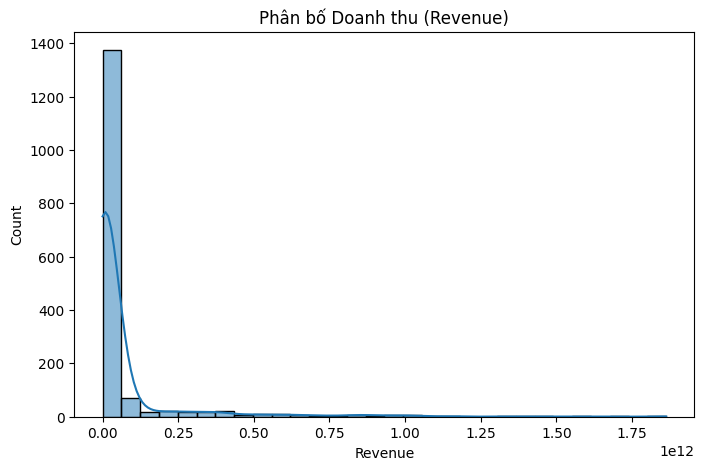

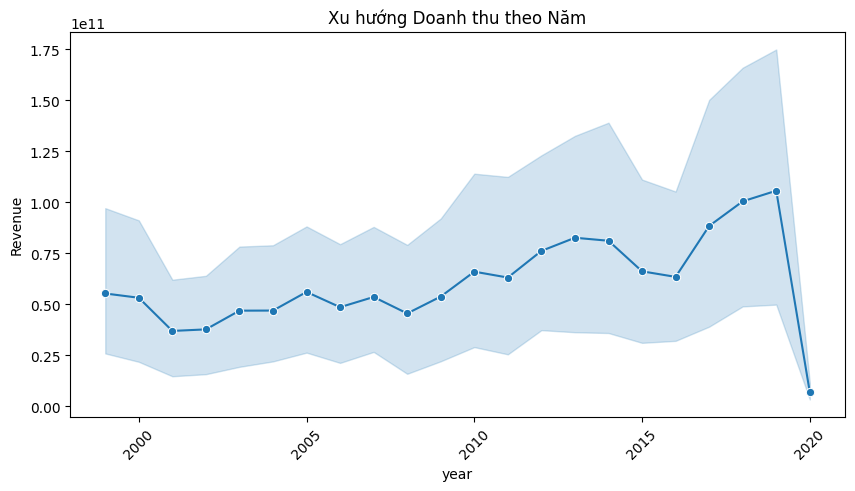

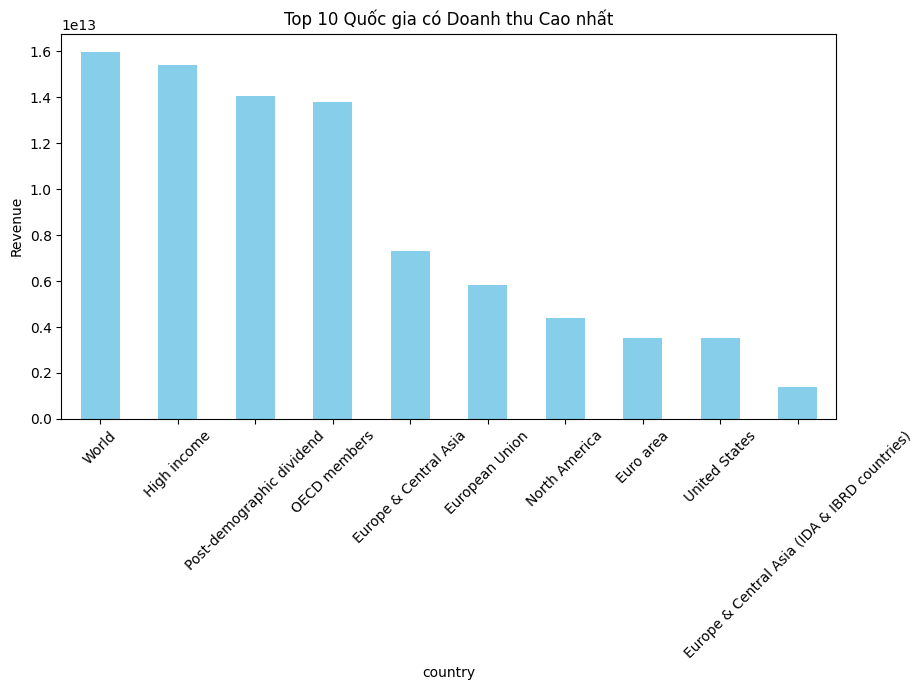

<ipython-input-8-f025d3259878>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="year", y="Revenue", data=df_pandas, palette="viridis")


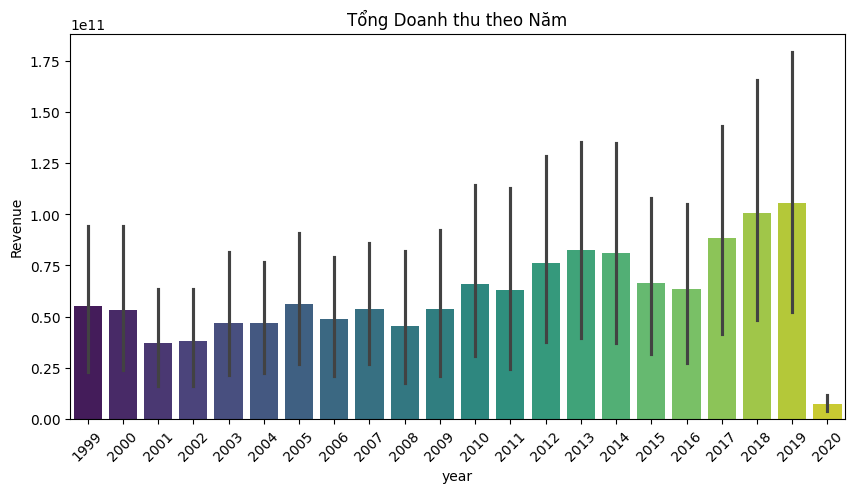

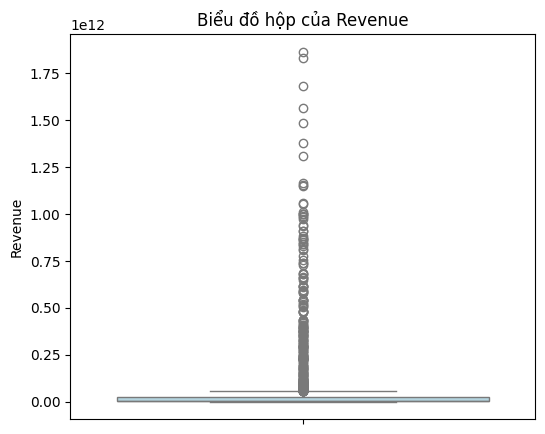

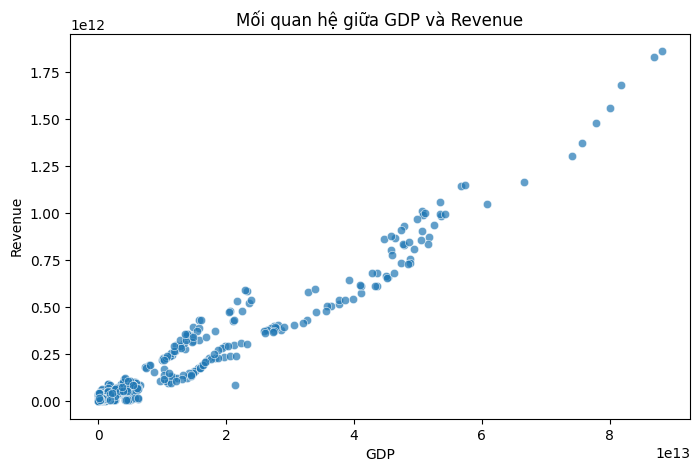

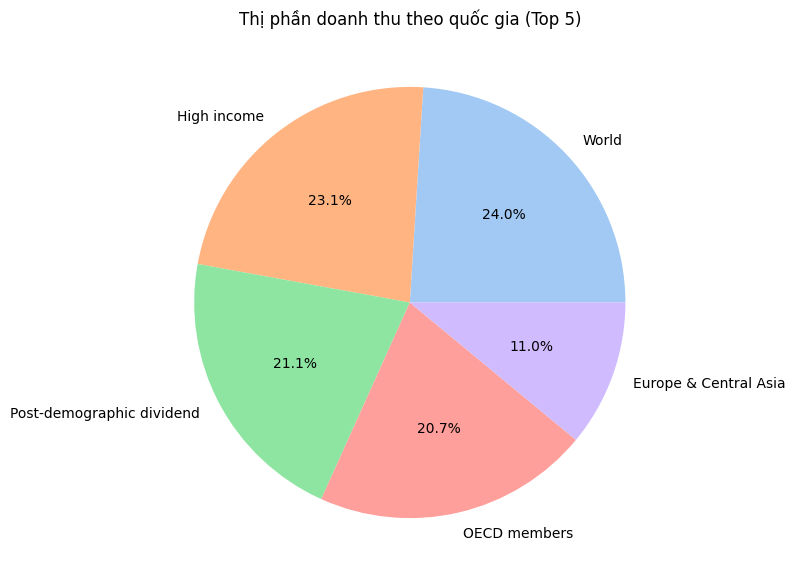

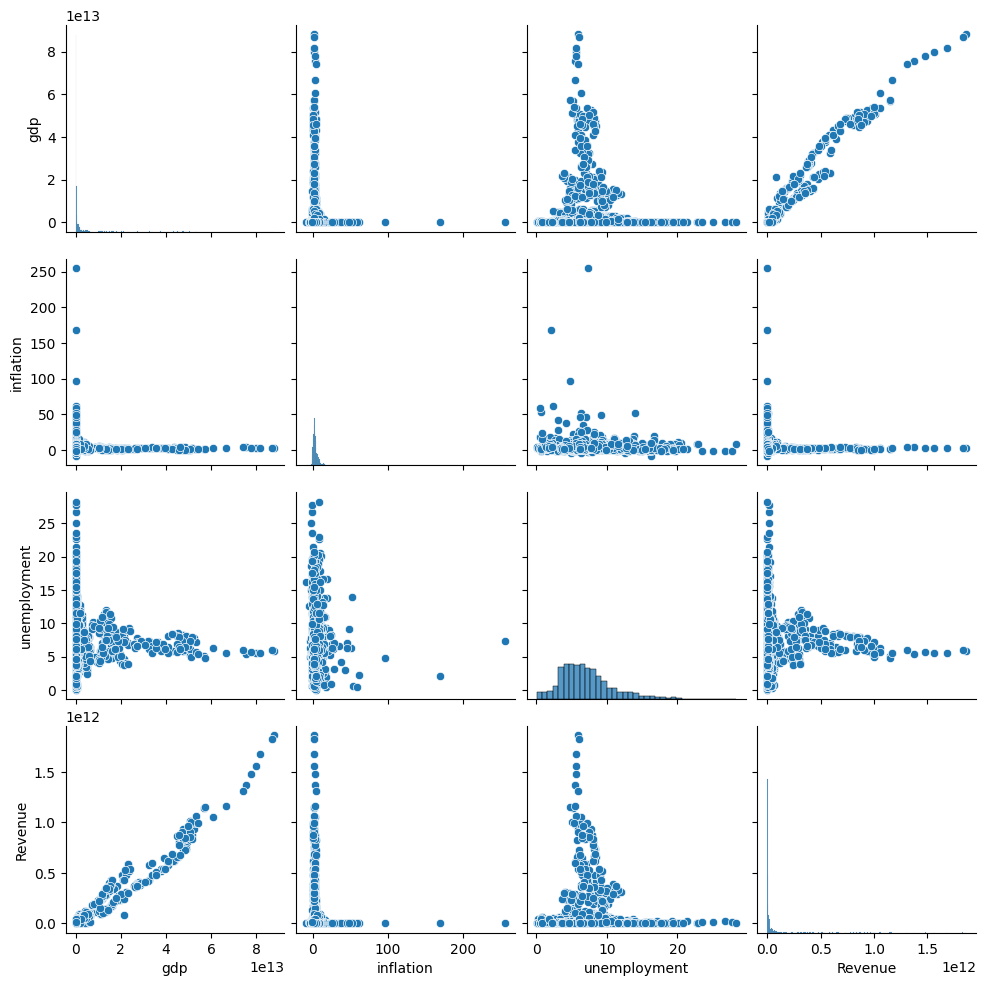

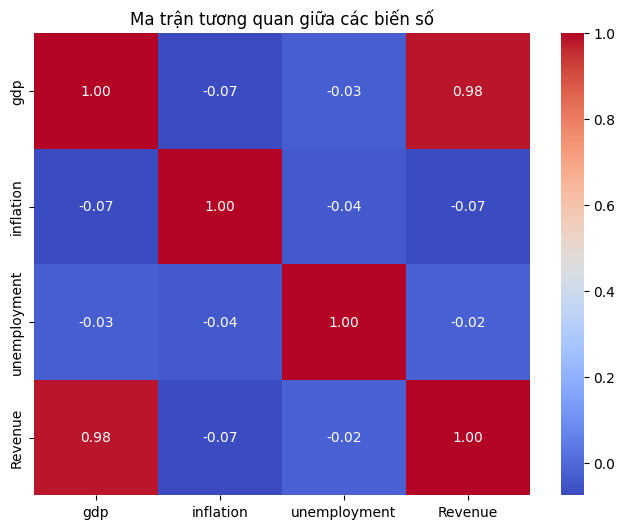

In [8]:
# Kiểm tra danh sách cột hiện có
print("📌 Danh sách cột trong DataFrame:", df.columns)

# Kiểm tra xem cột 'Revenue' có tồn tại không
if "Revenue" not in df.columns:
    print("⚠️ Cột 'Revenue' không tồn tại. Sử dụng 'tourism_receipts' làm Revenue.")
    df = df.withColumn("Revenue", col("tourism_receipts"))

# Bước 3: Kiểm tra dữ liệu bị thiếu
print("📌 Kiểm tra dữ liệu bị thiếu:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Xóa các dòng có giá trị null
df_cleaned = df.dropna()

# Loại bỏ dữ liệu trùng lặp
df_cleaned = df_cleaned.dropDuplicates()

# Chuyển kiểu dữ liệu Revenue sang double
df_cleaned = df_cleaned.withColumn("Revenue", col("Revenue").cast("double"))

# Chuyển từ PySpark DataFrame sang Pandas DataFrame để dễ vẽ biểu đồ
df_pandas = df_cleaned.toPandas()

# Hiển thị thống kê mô tả dữ liệu
print("📌 Thống kê mô tả dữ liệu:")
print(df_pandas.describe())

# Biểu đồ phân bố Revenue
plt.figure(figsize=(8,5))
sns.histplot(df_pandas["Revenue"], bins=30, kde=True)
plt.title("Phân bố Doanh thu (Revenue)")
plt.show()

# Biểu đồ xu hướng doanh thu theo năm
plt.figure(figsize=(10,5))
sns.lineplot(x="year", y="Revenue", data=df_pandas, marker="o")
plt.title("Xu hướng Doanh thu theo Năm")
plt.xticks(rotation=45)
plt.show()

# Biểu đồ tổng doanh thu theo quốc gia (Top 10 quốc gia)
top_countries = df_pandas.groupby("country")["Revenue"].sum().nlargest(10)
top_countries.plot(kind="bar", figsize=(10,5), color="skyblue")
plt.title("Top 10 Quốc gia có Doanh thu Cao nhất")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()

# Biểu đồ cột doanh thu theo năm
plt.figure(figsize=(10,5))
sns.barplot(x="year", y="Revenue", data=df_pandas, palette="viridis")
plt.title("Tổng Doanh thu theo Năm")
plt.xticks(rotation=45)
plt.ylabel("Revenue")
plt.show()

# Biểu đồ hộp để kiểm tra phân bố Revenue
plt.figure(figsize=(6,5))
sns.boxplot(y=df_pandas["Revenue"], color="lightblue")
plt.title("Biểu đồ hộp của Revenue")
plt.ylabel("Revenue")
plt.show()

# Nếu dữ liệu có GDP, vẽ biểu đồ phân tán giữa GDP và Revenue
if "gdp" in df_pandas.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="gdp", y="Revenue", data=df_pandas, alpha=0.7)
    plt.title("Mối quan hệ giữa GDP và Revenue")
    plt.xlabel("GDP")
    plt.ylabel("Revenue")
    plt.show()

# Biểu đồ tròn (Top 5 quốc gia có doanh thu cao nhất)
top_countries = df_pandas.groupby("country")["Revenue"].sum().nlargest(5)
plt.figure(figsize=(7,7))
plt.pie(top_countries, labels=top_countries.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Thị phần doanh thu theo quốc gia (Top 5)")
plt.show()

# Biểu đồ tán sắc (Pairplot) giữa GDP, Inflation, Unemployment và Revenue (nếu có đủ dữ liệu)
selected_features = ["gdp", "inflation", "unemployment", "Revenue"]
df_selected = df_pandas[selected_features].dropna()

if not df_selected.empty:
    sns.pairplot(df_selected)
    plt.show()

# Biểu đồ Heatmap thể hiện tương quan giữa các biến số
plt.figure(figsize=(8,6))
sns.heatmap(df_selected.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan giữa các biến số")
plt.show()
